<a href="https://colab.research.google.com/github/sxergiu/fac-year-3/blob/main/IPR/IPR3_Laboratory_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutions for images

First of all, we perform all the necessary imports. In order to ensure reproducibility, we set a constant seed for the random number generator in PyTorch using the `torch.manual_seed()` method.

In some circumstances, when given tensors on a CUDA device and using the CuDNN library, the cross-correlation operator in PyTorch may select a nondeterministic algorithm to increase performance. In order to ensure reproducibility, we can make the operation deterministic (potentially at a performance cost) by setting `torch.backends.cudnn.deterministic = True`.

Because the networks we discuss in this laboratory are rather big, we will need a GPU to train them, so please make sure the GPU hardware accelerator is selected in the *Change runtime type* dialog.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
!nvidia-smi

Fri Apr 29 07:06:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The two-dimensional cross-correlation operation is implemented in the `torch.nn.functional.conv2d()` function in PyTorch, which accepts an input tensor `X` and a kernel tensor `K` and returns an output tensor `Y`. The shape of the input tensor is $b\times c_{in}\times n_{h}\times n_{w}$, where $b$ is the batch size, $c_{in}$ is the number of channels in the input, and $n_{h}\times n_{w}$ is the shape of the input images. The shape of the kernel tensor is $c_{out} \times c_{in}\times k_{h}\times k_{w}$, where $c_{in}$ is the number of channels in the input, $c_{out}$ is the number of output channels, and $k_{h}$ and $k_{w}$ are the height and width of the kernel, respectively.

We test this function on the example in the course:

In [ ]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]]]])
F.conv2d(X, K)

tensor([[[[19., 25.],
          [37., 43.]]]])

#Padding and stride

Next, we illustrate two-dimensional cross-correlation with padding. We apply $1$ pixel of padding on all sides. We test this on the example in the course:

In [ ]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]]]])
F.conv2d(X, K, padding=1)

tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]])

For use as part of a network, PyTorch also has the `nn.Conv2d` layer. The first two parameters of the `nn.Conv2d` layer represent the number of input channels and the number of output channels, respectively. In the following example, we create a two-dimensional convolutional layer with a height and width of $3$ (specified by the `kernel_size` parameter), and apply $1$ pixel of padding on all sides (specified by the `padding` parameter). Given an input with a height and width of $8$, we find that the height and width of the output is also $8$.

In [ ]:
X = torch.rand(1, 1, 8, 8)
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
conv2d(X).shape

torch.Size([1, 1, 8, 8])

When the height and width of the convolution kernel are different, we can make the output and input have the same height and width by setting different padding numbers for height and width.

In [ ]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on either side of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
conv2d(X).shape

torch.Size([1, 1, 8, 8])

Cross-correlation with strides of $3$ and $2$ for height and width, respectively (specified using the `stride` parameter), can also be illustrated using the example in the course:

In [ ]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]]]])
F.conv2d(X, K, padding=1, stride=(3, 2))

tensor([[[[0., 8.],
          [6., 8.]]]])

Given an input with a height and width of $8$, below, we set the strides on both the height and width to $2$, thus halving the input height and width.

In [ ]:
X = torch.rand(1, 1, 8, 8)
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
conv2d(X).shape

torch.Size([1, 1, 4, 4])

Next, we will look at a slightly more complicated example.

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
conv2d(X).shape

torch.Size([1, 1, 2, 2])

#Multiple input and multiple output channels

We next illustrate the cross-correlation operation with $2$ input channels, i.e., $c_{in}=2$. The example in the course is now:

In [ ]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]]])
F.conv2d(X, K)

tensor([[[[ 56.,  72.],
          [104., 120.]]]])

In order to illustrate multiple output channels, we construct a convolution kernel with $3$ output channels by concatenating the kernel tensor `K` with `K+1` (plus one for each element in `K`) and `K+2`.

In [ ]:
K = torch.cat((K, K + 1, K + 2))
K.shape

torch.Size([3, 2, 2, 2])

Below, we perform cross-correlation operations on the input tensor `X` with the kernel tensor `K`. Now, the output contains $3$ channels. The result of the first channel is consistent with the result of the previous input tensor `X` and the multi-input channel, single-output channel kernel.

In [ ]:
F.conv2d(X, K)

tensor([[[[ 56.,  72.],
          [104., 120.]],

         [[ 76., 100.],
          [148., 172.]],

         [[ 96., 128.],
          [192., 224.]]]])

#Pooling

The maximum pooling and average pooling operations are implemented in PyTorch in the `torch.nn.functional.max_pool2d()` and `torch.nn.functional.avg_pool2d()` functions, respectively. The shape of the input tensor `X` is similar to the one for the `torch.nn.functional.conv2d()` function. By default, the `stride` parameter is set to be equal to `kernel_size`, so, if we want to reproduce the example in the course, we must set `kernel_size=2` and `stride=1` as parameters:

In [ ]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]]]])
F.max_pool2d(X, kernel_size=2, stride=1)

tensor([[[[4., 5.],
          [7., 8.]]]])

Also, we experiment with the average pooling operation.

In [ ]:
F.avg_pool2d(X, kernel_size=2, stride=1)

tensor([[[[2., 3.],
          [5., 6.]]]])

We can demonstrate the use of padding and strides in pooling layers via the built-in two-dimensional maximum pooling layer from PyTorch, i.e., the `nn.MaxPool2d` layer. We first construct an input tensor `X` whose shape has four dimensions, where the number of examples (batch size) and number of channels are both $1$.

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Again, by default, the stride and the pooling window in the `nn.MaxPool2d` class have the same shape. Below, we use a pooling window of shape $3\times 3$, so we get a stride shape of $3\times 3$, by default.

In [ ]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

The stride and padding can also be manually specified.

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

Of course, we can specify an arbitrary rectangular pooling window and specify the padding and stride for height and width, respectively.

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

When processing multi-channel input data, the pooling layer pools each input channel separately, rather than summing the inputs over channels, as in a convolutional layer. This means that the number of output channels for the pooling layer is the same as the number of input channels. Below, we concatenate tensors `X` and `X + 1` on the channel dimension to construct an input with $2$ channels.

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

As we can see, the number of output channels is still $2$ after pooling.

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

#Convolutional neural networks (LeNet)

While getting to the point where we truly understand what is going on inside LeNet may have taken a bit of work, hopefully the following code snippet will convince us that implementing such models with modern deep learning frameworks is remarkably simple. We need only to instantiate a `nn.Sequential` block and chain together the appropriate layers. Note the use of the `nn.Flatten` layer to reshape the 4D tensors processed by convolutional and pooling layers into 2D tensors, the only type a linear (fully-connected) layer can process.

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

By passing a single-channel (black and white) $28\times 28$ image through the network and printing the output shape at each layer, we can inspect the model to make sure that its operations line up with what we expect.

In [ ]:
X = torch.rand(1, 1, 28, 28)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


Note that the height and width of the representation at each layer throughout the convolutional block is reduced (compared with the previous layer). The first convolutional layer uses $2$ pixels of padding to compensate for the reduction in height and width that would otherwise result from using a $5\times 5$ kernel. In contrast, the second convolutional layer doesn't use padding, and thus the height and width are both reduced by $4$ pixels. As we go up the stack of layers, the number of channels increases layer-over-layer from $1$ in the input to $6$ after the first convolutional layer and $16$ after the second convolutional layer. However, each pooling layer halves the height and width. Finally, each fully-connected layer reduces dimensionality, finally emitting an output whose dimension matches the number of classes.

Now that we have implemented the model, let us run an experiment to see how LeNet performs on Fashion-MNIST.

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

While CNNs have fewer parameters, they can still be more expensive to compute than similarly deep MLPs, because each parameter participates in many more multiplications. That is why we need a GPU to speed up training.

For evaluation, we need to make a slight modification to the `evaluate_accuracy()` function that we described in *Laboratory 3*. Since the full dataset is in the main memory, we need to copy it to the GPU memory, before the model uses GPU to perform computations on the dataset.

In [ ]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

We also need to update our training function to deal with GPUs. Unlike the `train_epoch()` function defined in *Laboratory 3*, we now need to move each mini-batch of data to our designated device (hopefully, the GPU) prior to making the forward and backward propagations.

In [ ]:
def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

The training function `train()` is also similar to `train()` defined in *Laboratory 3*. Since we will be implementing networks with many layers going forward, we will rely primarily on high-level APIs. The following training function assumes a model created from high-level APIs as input, and is optimized accordingly. We initialize the model parameters on the device indicated by the `device` argument, using Xavier initialization. Just as with MLPs, our loss function is cross-entropy, and we minimize it via mini-batch stochastic gradient descent. We also evaluate the performance of our model on the test set.

In [ ]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

The `try_gpu()`, `plot_loss()`, and `plot_accuracy()` functions are the same as in *Laboratory 3*.

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Now let us train and evaluate the LeNet-5 model, and plot the training and validation losses and accuracies.

In [ ]:
batch_size, lr, num_epochs = 256, 0.9, 10
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Training on cuda:0
Epoch 1, Train loss 2.29, Train accuracy 12.39, Validation loss 1.88, Validation accuracy 34.41
Epoch 2, Train loss 1.20, Train accuracy 52.13, Validation loss 1.00, Validation accuracy 57.51
Epoch 3, Train loss 0.88, Train accuracy 64.76, Validation loss 0.83, Validation accuracy 67.48
Epoch 4, Train loss 0.76, Train accuracy 70.42, Validation loss 0.75, Validation accuracy 68.36
Epoch 5, Train loss 0.67, Train accuracy 73.76, Validation loss 0.66, Validation accuracy 75.54
Epoch 6, Train loss 0.62, Train accuracy 75.45, Validation loss 0.63, Validation accuracy 75.74
Epoch 7, Train loss 0.58, Train accuracy 77.38, Validation loss 0.56, Validation accuracy 77.74
Epoch 8, Train loss 0.54, Train accuracy 78.91, Validation loss 0.55, Validation accuracy 79.00
Epoch 9, Train loss 0.52, Train accuracy 79.82, Validation loss 0.55, Validation accuracy 78.99
Epoch 10, Train loss 0.49,

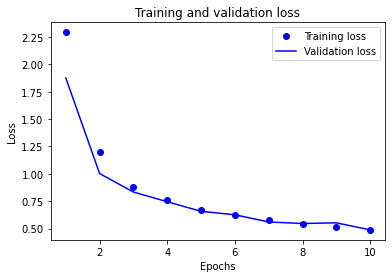

In [ ]:
plot_loss(train_loss_all, val_loss_all)

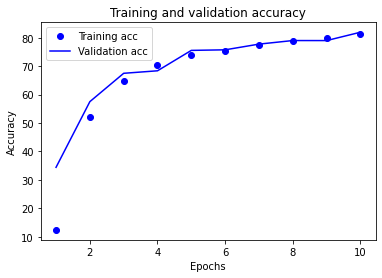

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)

#Deep convolutional neural networks (AlexNet)

The AlexNet model can also be easily implemented using the `nn.Sequential` class. Note that AlexNet changed the sigmoid activation function to a simpler ReLU activation function. AlexNet controls the model complexity of the fully-connected layer by dropout.

In [ ]:
net = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10))
net

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

We construct a single-channel data example with both height and width of $224$ to observe the output shape of each layer. It matches the AlexNet architecture presented in the course.

In [ ]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

Although AlexNet is trained on ImageNet in the paper, we use Fashion-MNIST here,
since training an ImageNet model to convergence could take hours or days
even on a modern GPU. One of the problems with applying AlexNet directly on Fashion-MNIST is that its images have lower resolution ($28 \times 28$ pixels)
than ImageNet images.To make things work, we upsample them to $224 \times 224$ (generally not a smart practice, but we do it here to be faithful to the AlexNet architecture). We perform this resizing with the `resize` argument in the `load_data_fashion_mnist()` function.

Now, we can start training AlexNet. Compared with LeNet,
the main change here is the use of a smaller learning rate
and much slower training, due to the deeper and wider network,
the higher image resolution, and the more costly convolutions.

In [ ]:
batch_size, lr, num_epochs = 128, 0.01, 5
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #22 min

Training on cuda:0
Epoch 1, Train loss 1.43, Train accuracy 47.30, Validation loss 0.79, Validation accuracy 71.21
Epoch 2, Train loss 0.69, Train accuracy 73.93, Validation loss 0.59, Validation accuracy 77.88
Epoch 3, Train loss 0.56, Train accuracy 78.64, Validation loss 0.47, Validation accuracy 82.36
Epoch 4, Train loss 0.49, Train accuracy 81.64, Validation loss 0.47, Validation accuracy 82.56
Epoch 5, Train loss 0.45, Train accuracy 83.43, Validation loss 0.44, Validation accuracy 83.09
Test loss 0.46, Test accuracy 82.30


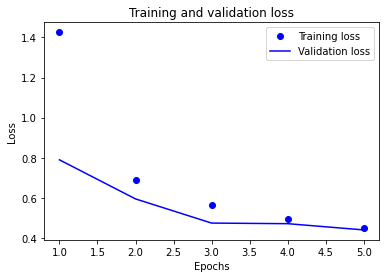

In [ ]:
plot_loss(train_loss_all, val_loss_all)

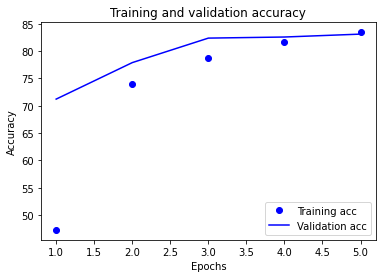

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)

#Networks using blocks (VGG)

The basic building block of classic CNNs
is a sequence of the following:
(i) a convolutional layer
with padding to maintain the resolution,
(ii) a nonlinearity, such as a ReLU,
(iii) a pooling layer, such
as a maximum pooling layer.
One VGG block consists of a sequence of convolutional layers,
followed by a maximum pooling layer for spatial downsampling.
In the original VGG paper, the authors employed convolutions with $3\times3$ kernels with padding of $1$ (keeping height and width)
and $2 \times 2$ maximum pooling with stride of $2$
(halving the resolution after each block).
In the code below, we define a function called `vgg_block()`
to implement one VGG block.

The function takes three arguments corresponding to the number
of convolutional layers `num_convs`, the number of input channels `in_channels`,
and the number of output channels `out_channels`.

In [ ]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

Like AlexNet and LeNet, the VGG network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers,
and the second consisting of fully-connected layers.

The convolutional part of the network connects several VGG blocks (defined in the `vgg_block()` function), in succession. The following variable `conv_arch` consists of a list of tuples (one per block), where each contains two values: the number of convolutional layers and the number of output channels, which are precisely the arguments required to call the `vgg_block()` function. The fully-connected part of the VGG network is identical to that covered in AlexNet.

The original VGG network had $5$ convolutional blocks, among which the first two have one convolutional layer each, and the latter three contain two convolutional layers each. The first block has $64$ output channels and each subsequent block doubles the number of output channels, until that number reaches $512$. Since this network uses $8$ convolutional layers and $3$ fully-connected layers, it is often called *VGG-11*.

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

The following code implements VGG-11. This is a simple matter of executing a for-loop over `conv_arch`.

In [ ]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

Next, we will construct a single-channel data example with a height and width of $224$ to observe the output shape of each layer.

In [ ]:
X = torch.randn(1, 1, 224, 224)
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


As we can see, we halve height and width at each block, finally reaching a height and width of $7$, before flattening the representations for processing by the fully-connected part of the network.

Since VGG-11 is more computationally-heavy than AlexNet, we construct a network with a smaller number of channels. This is more than sufficient for training on Fashion-MNIST.

In [ ]:
small_conv_arch = ((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))
net = vgg(small_conv_arch)
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Seque

Apart from using a slightly larger learning rate, the model training process is similar to that of AlexNet.

In [ ]:
batch_size, lr, num_epochs = 128, 0.05, 5
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #23 min

Training on cuda:0
Epoch 1, Train loss 0.97, Train accuracy 63.99, Validation loss 0.51, Validation accuracy 80.43
Epoch 2, Train loss 0.42, Train accuracy 84.52, Validation loss 0.43, Validation accuracy 82.55
Epoch 3, Train loss 0.35, Train accuracy 87.39, Validation loss 0.37, Validation accuracy 86.81
Epoch 4, Train loss 0.30, Train accuracy 89.01, Validation loss 0.29, Validation accuracy 89.19
Epoch 5, Train loss 0.27, Train accuracy 90.03, Validation loss 0.28, Validation accuracy 90.09
Test loss 0.29, Test accuracy 89.43


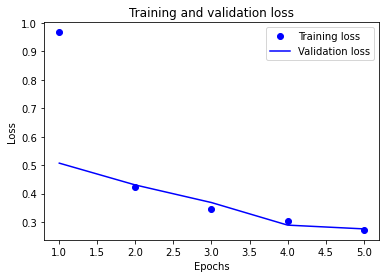

In [ ]:
plot_loss(train_loss_all, val_loss_all)

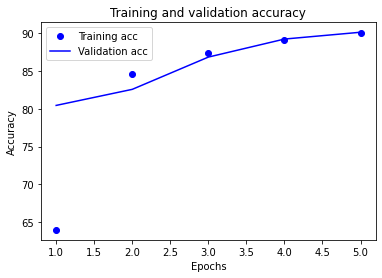

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)

#Batch normalization

To see how to apply batch normalization in context, below we apply it to a traditional LeNet model. Recall that batch normalization is applied after the convolutional layers or fully-connected layers, but before the corresponding activation functions. The corresponding layers in PyTorch are `nn.BatchNorm2d` for batch normalization applied after convolutional layers, and `nn.BatchNorm1d` for batch normalization applied after fully-connected layers. The first parameter represents the number of output channels of the previous layer.

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Sigmoid()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_features=120, bias=True)
  (10): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Sigmoid()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Sigmoid()
  (15): Linear(in_features=84, out_features=10, bias=True)
)

As before, we will train our network on the Fashion-MNIST dataset. This code is virtually identical to that when we first trained LeNet. The main difference is the larger learning rate.

In [ ]:
batch_size, lr, num_epochs = 256, 1.0, 10
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

Training on cuda:0
Epoch 1, Train loss 0.78, Train accuracy 71.68, Validation loss 0.96, Validation accuracy 70.69
Epoch 2, Train loss 0.51, Train accuracy 81.55, Validation loss 1.06, Validation accuracy 55.90
Epoch 3, Train loss 0.43, Train accuracy 84.07, Validation loss 0.95, Validation accuracy 66.55
Epoch 4, Train loss 0.39, Train accuracy 85.83, Validation loss 0.87, Validation accuracy 68.65
Epoch 5, Train loss 0.36, Train accuracy 86.84, Validation loss 0.69, Validation accuracy 76.37
Epoch 6, Train loss 0.34, Train accuracy 87.68, Validation loss 0.41, Validation accuracy 84.26
Epoch 7, Train loss 0.32, Train accuracy 88.16, Validation loss 0.60, Validation accuracy 78.05
Epoch 8, Train loss 0.31, Train accuracy 88.68, Validation loss 0.75, Validation accuracy 74.29
Epoch 9, Train loss 0.30, Train accuracy 88.99, Validation loss 0.61, Validation accuracy 79.96
Epoch 10, Train loss 0.29, Train accuracy 89.49, Validation loss 0.71, Validation accuracy 76.41
Test loss 0.73, Test

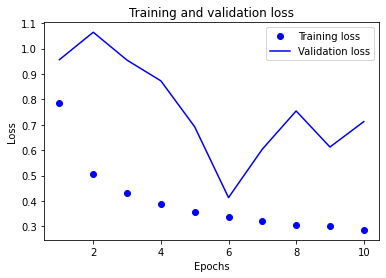

In [ ]:
plot_loss(train_loss_all, val_loss_all)

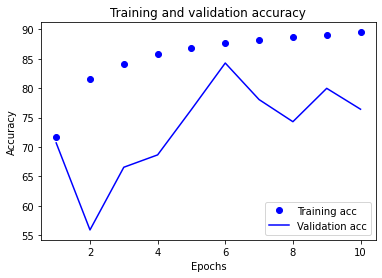

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)

Let us have a look at the scale parameter $\boldsymbol{\gamma}$ (`weight`) and the shift parameter $\boldsymbol{\beta}$ (`bias`) learned from the first batch normalization layer.

In [ ]:
net[1].weight.data, net[1].bias.data

(tensor([3.0325, 4.0037, 0.6372, 1.1454, 2.1352, 2.7692], device='cuda:0'),
 tensor([-1.9888,  1.8625,  0.6528,  1.6148, -2.0344,  2.9318], device='cuda:0'))

#Residual networks (ResNet)

ResNet follows VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires the output of the two convolutional layers to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let us have a look at the code below.

In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None

    def forward(self, X):
        Y = nn.ReLU()(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return nn.ReLU()(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity, whenever `use_1x1conv=False`, and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding.

Now, let us look at a situation where the input and output are of the same shape.

In [ ]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

We also have the option to halve the output height and width while increasing the number of output channels.

In [ ]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

The first two layers of ResNet are: a $7\times 7$ convolutional layer with $64$ output channels and a stride of $2$, followed by a $3\times 3$ maximum pooling layer with a stride of $2$. The batch normalization layer is added after each convolutional layer in ResNet.

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. Since a maximum pooling layer with a stride of $2$ has already been used, it is not necessary to reduce the height and width. In the first residual block, for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

Now, we implement this module. Note that special processing has been performed on the first module.

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module.

In [ ]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

Finally, we add a global average pooling layer, followed by the fully-connected layer output. The `nn.AdaptiveAvgPool2d` implements the global average pooling operation, ensuring that the output shape is the one given as its first parameter (in this case, $1\times 1$).

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-

There are $4$ convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully-connected layer, there are $18$ layers in total. Therefore, this model is commonly known as *ResNet-18*.

By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper $152$-layer *ResNet-152*.

Before training ResNet, let us observe how the input shape changes across different modules in ResNet. As in all the previous architectures, the resolution decreases while the number of channels increases, up until the point where a global average pooling layer aggregates all features.

In [ ]:
X = torch.rand(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


We train ResNet on the Fashion-MNIST dataset, just like before.

In [ ]:
batch_size, lr, num_epochs = 256, 0.05, 5
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #11 min

Training on cuda:0
Epoch 1, Train loss 0.50, Train accuracy 82.33, Validation loss 0.37, Validation accuracy 85.85
Epoch 2, Train loss 0.26, Train accuracy 90.25, Validation loss 0.43, Validation accuracy 83.40
Epoch 3, Train loss 0.20, Train accuracy 92.57, Validation loss 0.34, Validation accuracy 87.09
Epoch 4, Train loss 0.15, Train accuracy 94.49, Validation loss 0.26, Validation accuracy 90.59
Epoch 5, Train loss 0.11, Train accuracy 95.96, Validation loss 0.35, Validation accuracy 88.08
Test loss 0.37, Test accuracy 87.40


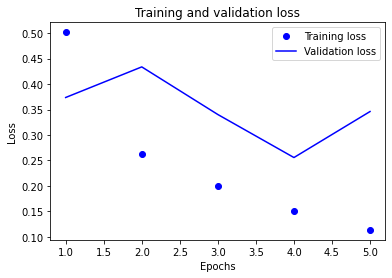

In [ ]:
plot_loss(train_loss_all, val_loss_all)

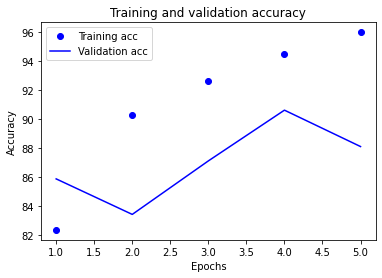

In [ ]:
plot_accuracy(train_acc_all, val_acc_all)